# EJERCICIO 2

Desarrollar un método computacional que, a partir de una img (y opcionalmente su máscara
de recorte), permita:
Identificar las imágenes que pertenecen a las categorı́as : “elephant” y “rhino”.
Proporcionar una evaluación cuantitativa adecuada de la identificaciones correspondientes

Es decir, clasificar cada img, considerando caracterı́sticas integradas para toda la img, región recortada y/o contorno, entre, por ejemplo, clase objetivo y resto

Primero cargaremos las imagenes y las etiquetas. Como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'. En una primera instancia no considereremos las máscaras de esta forma $X$ serán todas las imágenes e $Y$ sera la etiqueta asociada de entre {'rinoceronte', 'elefante', 'otros'}.

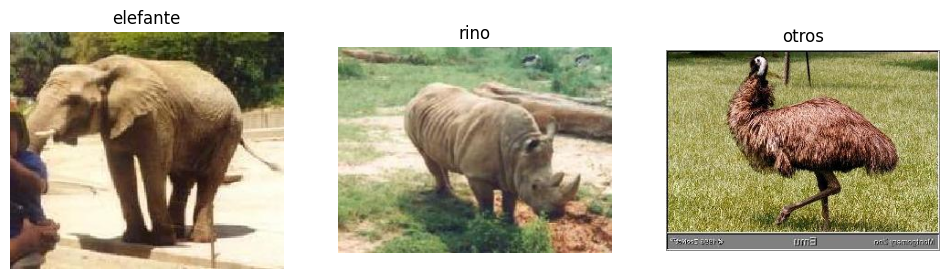

In [1]:
import glob
import skimage.io as io
import skimage.transform as tr
import matplotlib.pyplot as plt
import numpy as np

elefante = glob.glob("../objects/images/elephant/*.jpg") # rutas
rino = glob.glob("../objects/images/rhino/*.jpg")
emu = glob.glob("../objects/images/emu/*.jpg")
flamingo = glob.glob("../objects/images/flamingo/*.jpg")
otros = [*emu, *flamingo]

elefante = [io.imread(i) for i in elefante] #imageneoos
rino = [io.imread(i) for i in rino]
otros = [io.imread(i) for i in otros]


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(elefante[0])
plt.title("elefante")
plt.axis("off")

plt.subplot(132)
plt.imshow(rino[0])
plt.title("rino")
plt.axis("off")

plt.subplot(133)
plt.imshow(otros[0])
plt.title("otros")
plt.axis("off")

plt.show()

In [2]:
# primero cargaremos las imagenes, las etiquetas y eventualmente las máscaras
# como queremos diferenciar entre elefantes y rinocerontes, no nos vale la pena esforzarnos
# en distinguir si es un emu o un flamenco, entonces todo lo que no nos interese sera 'otros'

# en una primera instancia no considereremos las máscaras
# de esta forma X serán todas las imágenes e Y sera la etiqueta asociada

In [3]:
# ahora armamos X e Y

X = [*elefante, *rino, *otros]
Y =  [*['elefante']*len(elefante), *['rino']*len(rino), *['otros']*len(otros)]

In [4]:
# como hay imagenes en blanco y negro y en color, y eso supone diferencias de tamaño, voy a 
# tridimensionalizar las imagenes en blanco y negro. Triplicando la información que contienen.

def Tridimensionaliza(imagen):
    return np.array([[[imagen[i][j],imagen[i][j],imagen[i][j]] for i in range(np.shape(imagen)[0])] for j in range(np.shape(imagen)[1])])

# ademas, pasamos todos los elementos de X a arrays de numpy
X = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X ] 

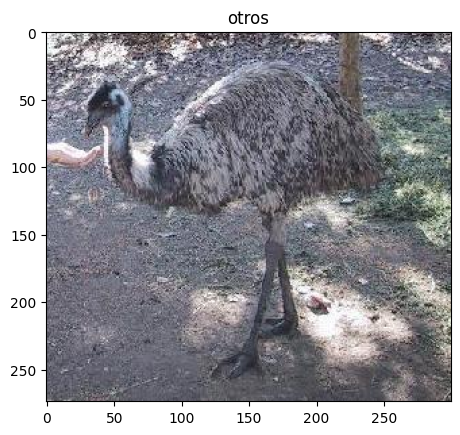

In [5]:
# (como simple demostracion de que lo anterior es correcto..
from random import randint as r

indice = r(0,len(X))

plt.imshow(X[indice])
plt.title(Y[indice])
plt.show()
# ...si al ejecutar, el titulo se corresponde con la imagen es que X e Y estan construidos segun nuestro deseo)

In [6]:
from math import ceil as techo
from random import shuffle as s

# Como cada imagen mide distinto las hacemos todas iguales. Además, las aplanamos

X = [np.array(tr.resize(i,(300,200))).flatten() for i in X]

# Para que nuestras conclusiones sean rigurosas, debemos O usar el error de validación O usar
# una partición de los datos en Entrenamiento y Test. Prodemos con la opción de test


# primero tendremos que desordenarlas, porque si le pasamos solo el final, tendra
# que clasificar exclusivamente 'otros' lo cual no nos interesa

temp = list(zip(X, Y))
s(temp)
X, Y = zip(*temp)


X_entrenamiento = X[:techo(len(X)*.8) ]
X_test =          X[ techo(len(X)*.8):]
Y_entrenamiento = Y[:techo(len(X)*.8) ]
Y_test =          Y[ techo(len(X)*.8):]

# Momento de entrenar

Como en el enunciado de la práctica no se entra en detalle de que algoritmo usar... lo científico por nuestra parte es probar los que nos _tengan sentido_ y ver cual da mejor resultado. Como primer intento, probaremos con KNN...

# Primer intento, sin mascaras con KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# que k usamos? vamos a ver cuantos datos tenemos
#
# $ print(f'hay {len(elefante)} elefantes y {len(rino)} rinocerontes')
# -> hay 64 elefantes y 59 rinocerontes
#
# usaremos un K de entorno a 50, por tanto (prepiero que descuide algunos 
# de su misma clase que que considere algunos de otras clases)

modelo1=KNeighborsClassifier(n_neighbors=50)
modelo1.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo1.predict(X_test)
print(classification_report(Y_predicho,Y_test))

              precision    recall  f1-score   support

    elefante       0.06      1.00      0.12         1
       otros       1.00      0.39      0.56        46
        rino       0.07      1.00      0.13         1

    accuracy                           0.42        48
   macro avg       0.38      0.80      0.27        48
weighted avg       0.96      0.42      0.54        48



In [8]:
# Malos resultados, pero curiosamente donde mejores resultados
# hubo fue en 'otros'. Vamos a probar a repetir todo pero sin 'otros'

# Segundo intento, sin mascaras con KNN y sin _otros_

In [10]:
X_sin = [*elefante, *rino]
Y_sin =  [*['elefante']*len(elefante), *['rino']*len(rino)]

temp = list(zip(X_sin, Y_sin))
s(temp)
X_sin, Y_sin = zip(*temp)


X_sin = [np.array(imagen) if len(np.shape(imagen)) == 3  else Tridimensionaliza(imagen) for imagen in X_sin ] 

X_sin = [np.array(tr.resize(i,(300,200))).flatten() for i in X_sin]

X_entrenamiento_sin = X_sin[:techo(len(X_sin)*.8) ]
X_test_sin =          X_sin[ techo(len(X_sin)*.8):]
Y_entrenamiento_sin = Y_sin[:techo(len(X_sin)*.8) ]
Y_test_sin =          Y_sin[ techo(len(X_sin)*.8):]

modelo2=KNeighborsClassifier(n_neighbors=50)
modelo2.fit(X_entrenamiento_sin,Y_entrenamiento_sin)
Y_predicho_sin = modelo2.predict(X_test_sin)
print(classification_report(Y_predicho_sin,Y_test_sin))

              precision    recall  f1-score   support

    elefante       0.38      0.71      0.50         7
        rino       0.82      0.53      0.64        17

    accuracy                           0.58        24
   macro avg       0.60      0.62      0.57        24
weighted avg       0.69      0.58      0.60        24



Observamos una mejora en los resultados, pero porque ahora la tarea es mucho más sencilla. Un modelo que no sepa nada acertaria en la mitad de las ocasiones.

# Tercer instento, con modelos lineales optimizador SGD

In [31]:
from sklearn.linear_model import SGDClassifier

modelo3 = SGDClassifier()
modelo3.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo3.predict(X_test)

In [32]:
sum([y[0] == y[1] for y in zip(Y_test,Y_predicho)])/len(Y_test)

0.5208333333333334

In [30]:
Y_predicho

array(['elefante', 'elefante', 'rino', 'otros', 'otros', 'otros',
       'elefante', 'otros', 'rino', 'otros', 'otros', 'elefante', 'rino',
       'otros', 'elefante', 'rino', 'elefante', 'rino', 'elefante',
       'otros', 'elefante', 'rino', 'otros', 'rino', 'elefante', 'otros',
       'elefante', 'otros', 'elefante', 'otros', 'otros', 'rino', 'otros',
       'otros', 'elefante', 'otros', 'elefante', 'otros', 'otros',
       'elefante', 'rino', 'rino', 'otros', 'rino', 'elefante',
       'elefante', 'otros', 'elefante'], dtype='<U8')